<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/HAR/wisdm_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [137]:
df=pd.read_csv("/content/drive/MyDrive/datasets/WISDM_ar_v1.1_raw.txt", header=None, on_bad_lines='skip').dropna()

In [138]:
df

,0,1,2,3,4,5
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
1086461,19,Sitting,131623331483000,9.000000,-1.570000,1.69;
1086462,19,Sitting,131623371431000,9.040000,-1.460000,1.73;
1086463,19,Sitting,131623411592000,9.080000,-1.380000,1.69;
1086464,19,Sitting,131623491487000,9.000000,-1.460000,1.73;


In [139]:
df.columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
df['z'] = df['z'].str.replace(';', '')
df=df.drop(columns=['timestamp']) #timestamp 열은 분석에 불필요하므로 제거한다.
df.head()

,user,activity,x,y,z
0,33,Jogging,-0.694638,12.680544,0.50395286
1,33,Jogging,5.012288,11.264028,0.95342433
2,33,Jogging,4.903325,10.882658,-0.08172209
3,33,Jogging,-0.612916,18.496431,3.0237172
4,33,Jogging,-1.184970,12.108489,7.205164


In [140]:
df.isnull().sum()

,0
user,0
activity,0
x,0
y,0
z,0


In [141]:
df['activity'].value_counts()

,count
activity,
Walking,418393
Jogging,336445
Upstairs,122869
Downstairs,100425
Sitting,59939
Standing,48394


In [142]:
#문자열로 되어 있는 숫자들을 실수로 바꿔주자
df['x']=df['x'].astype(float)
df['y']=df['y'].astype(float)
df['z']=df['z'].astype(float)

In [162]:
#라벨 인코딩 (activity를 숫자로)
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,x,y,z
0,33,1,-0.694638,12.680544,0.503953
1,33,1,5.012288,11.264028,0.953424
2,33,1,4.903325,10.882658,-0.081722
3,33,1,-0.612916,18.496431,3.023717
4,33,1,-1.184970,12.108489,7.205164


In [163]:
X=df.drop(columns=["activity","user"])
y=df["activity"]
X

,x,y,z
0,-0.694638,12.680544,0.503953
1,5.012288,11.264028,0.953424
2,4.903325,10.882658,-0.081722
3,-0.612916,18.496431,3.023717
4,-1.184970,12.108489,7.205164
...,...,...,...
1086461,9.000000,-1.570000,1.690000
1086462,9.040000,-1.460000,1.730000
1086463,9.080000,-1.380000,1.690000
1086464,9.000000,-1.460000,1.730000


In [164]:
y

,activity
0,1
1,1
2,1
3,1
4,1
...,...
1086461,2
1086462,2
1086463,2
1086464,2


In [165]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.197600,0.806331,0.022317,1
1,0.632345,0.596159,0.116722,1
2,0.616498,0.539574,-0.100695,1
3,-0.185715,1.669250,0.551556,1
4,-0.268908,0.721454,1.429807,1
...,...,...,...,...
1086460,1.212268,-1.308060,0.271429,2
1086461,1.218085,-1.291739,0.279830,2
1086462,1.223902,-1.279869,0.271429,2
1086463,1.212268,-1.291739,0.279830,2


In [166]:
#CNN은 고정된 크기의 입력만 처리할 수 있기 때문에 데이터를 일정한 윈도우 단위로 잘라주어야 한다.
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [167]:
from scipy import stats
import numpy as np

In [181]:

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        label = int(stats.mode(df['label'][i: i + frame_size], keepdims=False).mode)
        frames.append([x, y, z])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [182]:
X,y =get_frames(scaled_X, frame_size, hop_size)

In [183]:
X.shape, y.shape

((27160, 80, 3), (27160,))

In [184]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)

In [185]:
X_train.shape, X_test.shape

((21728, 80, 3), (5432, 80, 3))

In [186]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [187]:
X_train=X_train.reshape((21728, 80, 3, 1))
X_test=X_test.reshape((5432, 80, 3, 1))

In [188]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [189]:

model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [190]:
model.compile(optimizer=Adam(1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [191]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 79, 2, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 79, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 78, 1, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 78, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2496)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │       159,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,358 (634.21 KB)

 Trainable params: 162,358 (634.21 KB)

 Non-trainable params: 0 (0.00 B)

In [192]:
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6741 - loss: 0.8863 - val_accuracy: 0.8362 - val_loss: 0.4465
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8172 - loss: 0.4963 - val_accuracy: 0.8573 - val_loss: 0.3770
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8405 - loss: 0.4211 - val_accuracy: 0.8706 - val_loss: 0.3193
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8560 - loss: 0.3781 - val_accuracy: 0.8840 - val_loss: 0.3009
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8735 - loss: 0.3367 - val_accuracy: 0.8873 - val_loss: 0.2839
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8820 - loss: 0.3136 - val_accuracy: 0.9159 - val_loss: 0.2477
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8926 - loss: 0.2861 - val_accuracy: 0.9155 - val_loss: 0.2340
Epoch 8/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8974 - loss: 0.2748 - val

In [197]:
import matplotlib.pyplot as plt

In [198]:

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

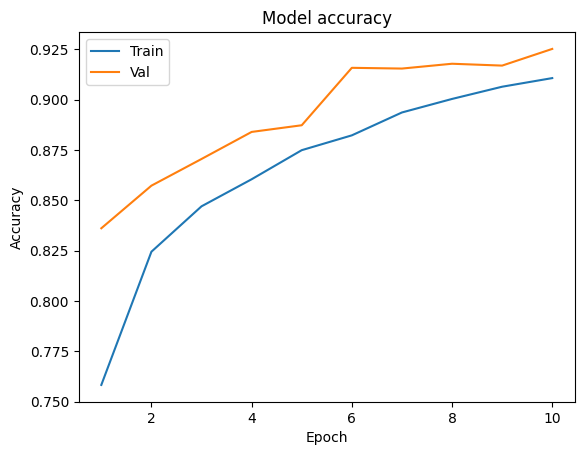

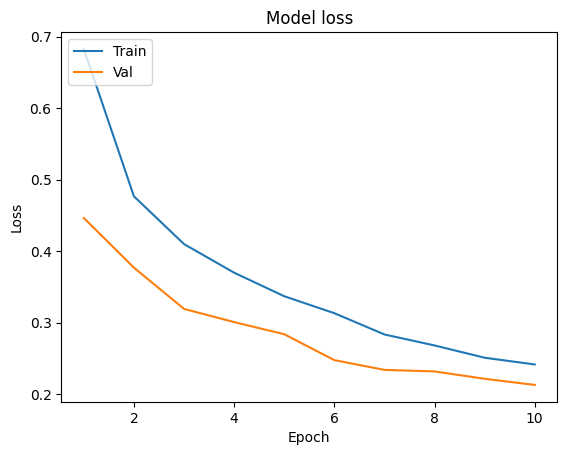

In [199]:
plot_learningCurve(history, 10)

In [202]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [203]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

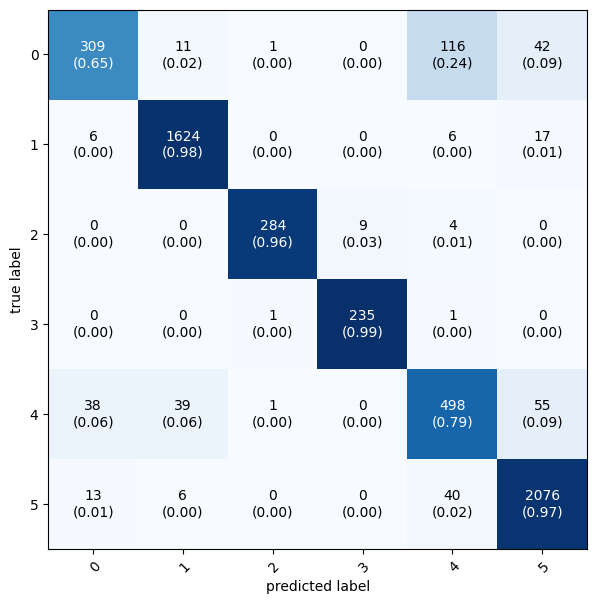

In [204]:
mat=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))